# Autoencoders for Anomaly Detection

Author: Evelyn Fitzgerald (with Lijing Wang)

The goal of this notebook was to implement a convolutional autoencoder for anomaly detection. The idea was to frame the problem of detecting physical signs of blight on buildings as an anomaly detection problem: buildings with high upkeep have a regular appearance, but blight looks like irregularities in a building's appearance. This is called the [Anna Karenina principle](https://en.wikipedia.org/wiki/Anna_Karenina_principle): "All happy families are alike; each unhappy family is unhappy in its own way."

The anomaly detector works by dividing the input image into 8x8 pixel blocks (and 16x16 blocks scaled down to 8x8) and feeding each block through the autoencoder to reconstruct it based on learned patterns. The mean squared error of the reconstruction is used to determine whether the image is an anomaly: we fit a normal distribution to the distribution of MSEs observed during training, and then take a one-sided p-value of the observed MSEs of the reconstructions. If any of the p-values is smaller than a threshold set by the user (e.g. 0.005), then the image is considered anomalous.

The problem with anomaly detection is that it treats any visual features that are underrepresented in the dataset as anomalies. For example, text signs don't appear often in the dataset, so they may be treated as anomalies even though they are not indicators of blight. Overall, our anomaly detector performed poorly relative to the original classifiers that were trained for this task.

Here are some of the sources we used for inspiration when designing the autoencoder:

- https://blog.keras.io/building-autoencoders-in-keras.html
- https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763
- https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/


In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm, trange

import numpy as np
import statistics
from scipy.stats import norm

from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm, classification_report as cr
from sklearn.manifold import TSNE

from data import get_loader

See https://github.com/Changing-Cities-Research-Lab/gsv-ml-buildings-new for descriptions of CLI args

In [2]:
# Mock CLI args
args = {
    'pretrain': False,
    'label_type': 'lh', # binary classification - 0 if == 0, 1; 1 if == 2, 3
    'batch_size': 16,
    'lr': 3e-5, # set larger learning rate because we're not fine-tuning the NN (or just try 1e-5)
    'l2': 3e-4,
    'gpu': True,
    'weighted': False, # we DON'T want to learn features of minority class
    'upsample': False,
    'add_bos': True,
    'data_path': '../../gsv-ml-buildings-new' # Use main gsv directory instead of os.chdir
}

In [3]:
train_loader = get_loader('train', args)
val_loader = get_loader('val', args)

In [4]:
# The number of channels in each layer of the convnet pyramid (following EfficientNet-B0)
# except that the last layer has 216 channels instead of 1280
C = [3, 24, 40, 112, 216]
# output_dim = 2048

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Layers follow a pyramidal shape:
        # Decreasing width: 224 -> 112 -> 56 -> 28 -> 14 -> 7
        # Increasing depth (# of channels)
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(C[0], C[1], 3, padding=1), # 224
            nn.Conv2d(C[1], C[2], 3, padding=1), # 112
            nn.Conv2d(C[2], C[3], 3, padding=1), # 56
        ])
        # Decoder structure is inverse of encoder structure
        self.deconv_layers = nn.ModuleList([
            nn.ConvTranspose2d(C[3], C[2], 3, stride=2, padding=1, output_padding=1), # 28 -> 56
            nn.ConvTranspose2d(C[2], C[1], 3, stride=2, padding=1, output_padding=1), # 56 -> 112
            nn.ConvTranspose2d(C[1], C[0], 3, stride=2, padding=1, output_padding=1), # 112 -> 224
        ])
        # Misc. layers
        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(2)
        # Final layers
        self.last_conv = nn.ConvTranspose2d(C[0], C[0], 3, padding=1)
    
    def forward(self, x):
        skip_connections = {}
        # Encoder
        for i, conv in enumerate(self.conv_layers):
            x = conv(x)
            x = self.activation(x)
            x = self.pooling(x)
            if i == 0:
                skip_connections[i] = x  # 112*112*24
        # Decoder
        for i, conv in enumerate(self.deconv_layers):
            x = conv(x)
            x = self.activation(x)
            # Add skip connection
            j = len(self.deconv_layers) - i - 2
            if j in skip_connections:
                x += skip_connections[j]
        x = self.last_conv(x)
        return x

In [5]:
def run_autoencoder(mode, model, loader, loss_criterion, optimizer, args, e=None, loss_values=[]):
    '''Same parameters as utils.run()'''
    if mode == 'train': model.train()
    else: model.eval()
    
    # Loss values from the current epoch
    cur_loss_values = []
    
    # Transform: randomly scale down the input images by half
    # This increases the receptive field of the encoder from 8x8 to 16x16, relative to the original image
    transform = transforms.RandomApply(nn.ModuleList([
        transforms.Resize(size=112)
    ]), p=0.5)
    
    for img, label in tqdm(loader, desc=f'{mode} {e+1}' if e is not None else mode):
        # Only do a step if there are any normal (1) examples
        if torch.count_nonzero(label).item() > 0:
            if args['gpu']: img, label = img.cuda(), label.cuda()
            if mode == 'train': optimizer.zero_grad()

            # During training, randomly resize the batch
            if mode == 'train':
                img = transform(img)

            # Output should have same shape as input
            img_out = model(img)

            # Compute losses
            losses = loss_criterion(img_out, img)
            # Need to average the losses for all pixels in each image
            losses = torch.mean(losses, dim=(1, 2, 3))
            # Then, zero out losses for anomalous images and average them
            # (0 = blighted buildings = anomalous images)
            loss = torch.mean(losses * label)

            if mode == 'train':
                loss.backward()
                optimizer.step()

            cur_loss_values.append(loss.item())
    
    if mode == 'train':
        loss_values.extend(cur_loss_values)
    
    # Report sample mean and standard deviation of cur_loss_values
    mean = statistics.fmean(cur_loss_values)
    stdev = statistics.stdev(cur_loss_values)
    print(f'MSE loss: mean = {mean:.3f}, std = {stdev:.3f}, 95% CI = [{mean - 2*stdev:.3f}, {mean + 2*stdev:.3f}]')
    return mean, stdev

## Run everything below this line:

In [6]:
torch.manual_seed(94305)
autoencoder = Autoencoder().cuda()

loss_criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(autoencoder.parameters(), lr=args['lr'], weight_decay=args['l2'])

In [7]:
loss_values = []
for i in trange(4):
    run_autoencoder('train', autoencoder, train_loader, loss_criterion, optimizer, args, e=i, loss_values=loss_values)
    run_autoencoder('eval', autoencoder, val_loader, loss_criterion, optimizer, args, e=i)

  0%|          | 0/4 [00:00<?, ?it/s]

train 1:   0%|          | 0/435 [00:00<?, ?it/s]

MSE loss: mean = 0.858, std = 0.237, 95% CI = [0.385, 1.332]


eval 1:   0%|          | 0/109 [00:00<?, ?it/s]

MSE loss: mean = 0.342, std = 0.067, 95% CI = [0.207, 0.477]


train 2:   0%|          | 0/435 [00:00<?, ?it/s]

MSE loss: mean = 0.214, std = 0.069, 95% CI = [0.076, 0.353]


eval 2:   0%|          | 0/109 [00:00<?, ?it/s]

MSE loss: mean = 0.136, std = 0.030, 95% CI = [0.075, 0.196]


train 3:   0%|          | 0/435 [00:00<?, ?it/s]

MSE loss: mean = 0.137, std = 0.035, 95% CI = [0.067, 0.208]


eval 3:   0%|          | 0/109 [00:00<?, ?it/s]

MSE loss: mean = 0.101, std = 0.022, 95% CI = [0.057, 0.145]


train 4:   0%|          | 0/435 [00:00<?, ?it/s]

MSE loss: mean = 0.112, std = 0.028, 95% CI = [0.055, 0.169]


eval 4:   0%|          | 0/109 [00:00<?, ?it/s]

MSE loss: mean = 0.082, std = 0.018, 95% CI = [0.046, 0.118]


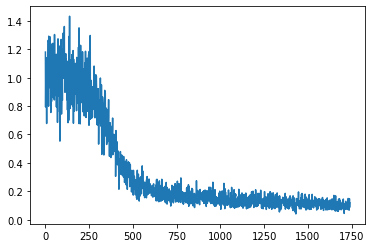

In [8]:
plt.plot(loss_values)

## Anomaly Detection

Procedure for using autoencoder for anomaly detection:
1. Pass image through autoencoder (encoder and decoder)
2. Compute MSE loss
3. Compute one-sided p-value for loss (p = Pr(image belongs to normal class))
4. If p < 0.05 (MSE > threshold), image is most likely anomalous


In [9]:
class AnomalyDetector(nn.Module):
    def __init__(self, autoencoder, p_thresh):
        super().__init__()
        self.autoencoder = autoencoder
        self.mse = nn.MSELoss(reduction='none')
        self.avgpool = nn.AvgPool2d(8)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.downsample = nn.AvgPool2d(2)
        self.dist = torch.distributions.normal.Normal(0.0, 1.0)
        self.p_thresh = p_thresh
    
    def compute_losses(self, img):
        '''Compute losses for 8*8 blocks of the image.'''
        img_out = self.autoencoder(img)
        losses = self.mse(img, img_out)
        losses = torch.mean(self.avgpool(losses), 1, True) # collapse channels and keep channel dimension
        return losses
    
    def compute_global_losses(self, img):
        losses = self.compute_losses(img)
        losses = self.maxpool(losses)
        losses = torch.reshape(losses, (-1,))
        return losses
    
    def p_values(self, img):
        '''Compute one-sided p-values'''
        img_scaled = self.downsample(img)
        losses_8px = self.compute_global_losses(img)
        losses_16px = self.compute_global_losses(img_scaled)
        losses = torch.maximum(losses_8px, losses_16px)
        p = 1 - self.dist.cdf(losses)
        return p
    
    def forward(self, img):
        # Do one-sided p-value test
        p = self.p_values(img)
        # 0 = anomaly
        y_pred = torch.where(p <= self.p_thresh, 0, 1)
        return y_pred

In [10]:
anomaly_detector = AnomalyDetector(autoencoder, 0.005).cuda()

In [11]:
def fit_anomaly_detector(loader, autoencoder, anomaly_detector):
    with torch.no_grad():
        all_losses = []

        for img, label in tqdm(loader, desc='Fit anomaly detector'):
            # Only do a step if there are any normal (1) examples
            if torch.count_nonzero(label).item() > 0:
                if args['gpu']: img, label = img.cuda(), label.cuda()

                # Compute loss values for all 8*8 blocks in images
                # Only keep the losses for normal (1) examples
                losses = anomaly_detector.compute_losses(img)[label == 1]
                all_losses.append(losses)

        all_losses = torch.cat(all_losses, dim=0)
        stdev, mean = torch.std_mean(all_losses, unbiased=True)
        anomaly_detector.dist = torch.distributions.normal.Normal(mean, stdev)
        print(f'mean = {mean:.4f}, stdev = {stdev:.4f}')

In [12]:
fit_anomaly_detector(val_loader, autoencoder, anomaly_detector)

Fit anomaly detector:   0%|          | 0/109 [00:00<?, ?it/s]

mean = 0.0960, stdev = 0.0994


In [13]:
def anomaly_detection_prc(anomaly_detector, loader, args):
    anomaly_detector.eval()
    
    y_true_all_batches, y_scores_all_batches = [], []
    
    for img, label in tqdm(loader, desc='Compute anomaly detector ROC'):
        y_true = label.numpy()
        if args['gpu']: img, label = img.cuda(), label.cuda()
        # Get anomaly detection scores (p-values)
        y_scores = anomaly_detector.p_values(img).cpu().detach().numpy()
        y_true_all_batches.append(y_true)
        y_scores_all_batches.append(y_scores)
    
    y_true_all = np.concatenate(y_true_all_batches)
    y_scores_all = np.concatenate(y_scores_all_batches)
    
    # roc_curve, RocCurveDisplay
    return metrics.precision_recall_curve(1 - y_true_all, 1 - y_scores_all), metrics.average_precision_score(1 - y_true_all, 1 - y_scores_all)

In [14]:
(precision, recall, thresholds), ap = anomaly_detection_prc(anomaly_detector, val_loader, args)

Compute anomaly detector ROC:   0%|          | 0/109 [00:00<?, ?it/s]

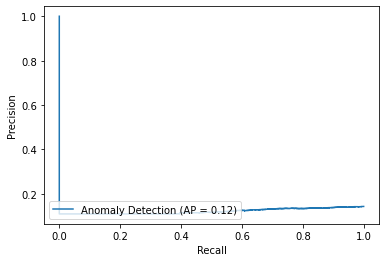

In [15]:
metrics.PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='Anomaly Detection', average_precision=ap).plot()

In [16]:
def anomaly_detection_roc(anomaly_detector, loader, args):
    anomaly_detector.eval()
    
    y_true_all_batches, y_scores_all_batches = [], []
    
    for img, label in tqdm(loader, desc='Compute anomaly detector ROC'):
        y_true = label.numpy()
        if args['gpu']: img, label = img.cuda(), label.cuda()
        # Get anomaly detection scores (p-values)
        y_scores = anomaly_detector.p_values(img).cpu().detach().numpy()
        y_true_all_batches.append(y_true)
        y_scores_all_batches.append(y_scores)
    
    y_true_all = np.concatenate(y_true_all_batches)
    y_scores_all = np.concatenate(y_scores_all_batches)
    
    # roc_curve, RocCurveDisplay
    return metrics.roc_curve(1 - y_true_all, 1 - y_scores_all)

In [17]:
fpr, tpr, thresholds = anomaly_detection_roc(anomaly_detector, val_loader, args)

Compute anomaly detector ROC:   0%|          | 0/109 [00:00<?, ?it/s]

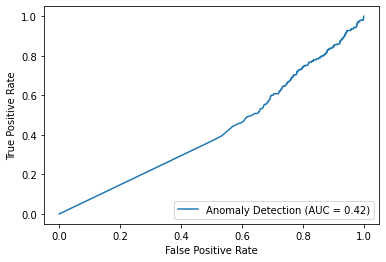

In [18]:
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Anomaly Detection', roc_auc=metrics.auc(fpr, tpr)).plot()

In [19]:
def eval_anomaly_detection(anomaly_detector, loader, args):
    anomaly_detector.eval()
    
    y_true_all_batches, y_pred_all_batches = [], []
    
    for img, label in tqdm(loader, desc='Eval anomaly detection'):
        y_true = label.numpy()
        if args['gpu']: img, label = img.cuda(), label.cuda()
        y_pred = anomaly_detector(img).cpu().detach().numpy()
        y_true_all_batches.append(y_true)
        y_pred_all_batches.append(y_pred)
    
    y_true_all = np.concatenate(y_true_all_batches)
    y_pred_all = np.concatenate(y_pred_all_batches)
    
    print(cr(y_true_all, y_pred_all, target_names=['anomalous (0)', 'normal (1)']))
    return y_true_all, y_pred_all

In [20]:
anomaly_detector.p_thresh = 0.01

In [21]:
y_true_all, y_pred_all = eval_anomaly_detection(anomaly_detector, val_loader, args)

Eval anomaly detection:   0%|          | 0/109 [00:00<?, ?it/s]

               precision    recall  f1-score   support

anomalous (0)       0.14      0.94      0.24       250
   normal (1)       0.78      0.04      0.07      1491

     accuracy                           0.17      1741
    macro avg       0.46      0.49      0.16      1741
 weighted avg       0.69      0.17      0.10      1741



In [22]:
cm(y_true_all, y_pred_all)

array([[ 234,   16],
       [1434,   57]])

## Baselines

* **Random guessing:** Each prediction is a Bernoulli trial whose probabilities are the class frequencies in the training set.
  - Goal: Get an accurate sense of what the precision and recall should be
* **Majority baseline:** Always predict the most frequent class
  - Goal: Get an "accurate" sense of what the accuracy should be
  - Problem: Anomalies are the minority, so precision is always undefined and recall is always 0


In [23]:
frequencies = np.unique(train_loader.dataset.labels, return_counts=True)[1] / len(train_loader.dataset.labels)

In [24]:
frequencies

array([0.15059635, 0.84940365])

In [25]:
y_true = val_loader.dataset.labels

In [26]:
len(y_true)

1741

In [27]:
y_pred = np.random.choice(2, p=frequencies, size=len(y_true))

In [28]:
print(cr(y_true, y_pred, target_names=['anomalous (0)', 'normal (1)']))

               precision    recall  f1-score   support

anomalous (0)       0.15      0.16      0.16       250
   normal (1)       0.86      0.84      0.85      1491

     accuracy                           0.74      1741
    macro avg       0.50      0.50      0.50      1741
 weighted avg       0.76      0.74      0.75      1741



In [29]:
maj_baseline = np.ones_like(y_true)

In [30]:
print(cr(y_true, maj_baseline, target_names=['anomalous (0)', 'normal (1)']))

               precision    recall  f1-score   support

anomalous (0)       0.00      0.00      0.00       250
   normal (1)       0.86      1.00      0.92      1491

     accuracy                           0.86      1741
    macro avg       0.43      0.50      0.46      1741
 weighted avg       0.73      0.86      0.79      1741



/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## t-SNE

In [31]:
def get_dataset_tsne(loader, batches=None):
    X_all, y_all = [], []
    for i, (img, label) in enumerate(tqdm(loader, desc='Get batches')):
        if i == batches:
            break
        # Flatten all images
        N = img.shape[0]
        X_all.append(img.numpy().reshape((N, -1)))
        y_all.append(label.numpy())
    X = np.concatenate(X_all)
    y = np.concatenate(y_all)
    return X, y

In [32]:
X, y = get_dataset_tsne(val_loader)

Get batches:   0%|          | 0/109 [00:00<?, ?it/s]

In [33]:
X.shape

(1741, 150528)

In [34]:
# Original seed: 94305
tsne = TSNE(n_components=2, n_jobs=-1, random_state=94310)
X_embedded = tsne.fit_transform(X[:480])

In [35]:
X_embedded.shape

(480, 2)

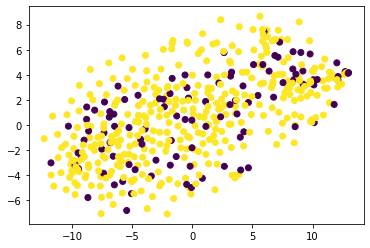

In [36]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y[:480])

In [37]:
scores = val_loader.dataset.csv['score']

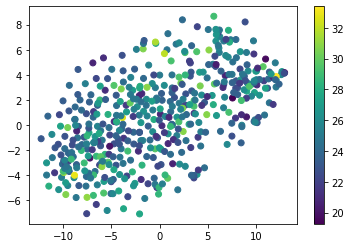

In [38]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=scores[:480])
plt.colorbar()

## Visualizing Outputs

In [39]:
def get_batch(loader):
    return next(iter(loader))

In [40]:
def make_img_array(img_tensor):
    img_npy = img_tensor.cpu().detach().numpy()
    img_npy = np.swapaxes(img_npy, 1, -1)
    return img_npy

In [41]:
def normalize_img(img_npy):
    # Normalize to [0, 1]
    amin, amax = np.min(img_npy), np.max(img_npy)
    return (img_npy - amin) / (amax - amin)

def visualize_in_out(i, normalize=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9.5, 3))
    ax1.imshow(imgs_npy[i].transpose(1, 0, 2))
    ax2.imshow(normalize_img(imgs_out_npy[i].transpose(1, 0, 2)) if normalize else imgs_out_npy[i].transpose(1, 0, 2))
    mse_img = ax3.imshow(img_mse_map_npy[i, 0])
    fig.colorbar(mse_img, ax=ax3)

In [42]:
img, label = get_batch(val_loader)

In [43]:
img = img.cuda()

In [44]:
y_pred = anomaly_detector(img).cpu().detach().numpy()
y_true = label.numpy()

In [45]:
img_mse_map = anomaly_detector.compute_losses(img)

In [46]:
img_mse_map_npy = img_mse_map.cpu().detach().numpy()

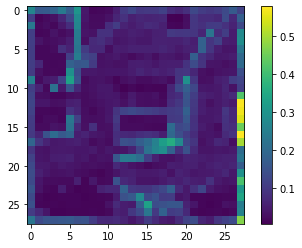

In [47]:
plt.imshow(img_mse_map_npy[0, 0])
plt.colorbar()

In [48]:
cm(y_true, y_pred)

array([[ 2,  1],
       [12,  1]])

In [49]:
imgs_out = autoencoder(img.cuda())

In [50]:
imgs_npy = make_img_array(img)
imgs_out_npy = make_img_array(imgs_out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


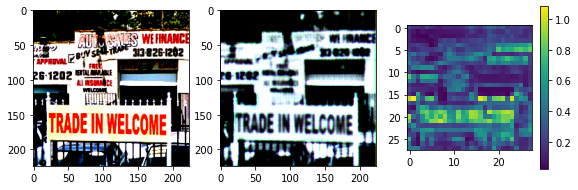

In [51]:
visualize_in_out(5, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


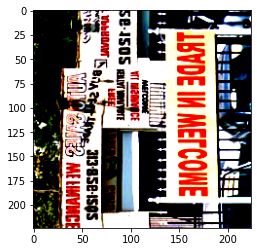

In [52]:
plt.imshow(imgs_npy[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


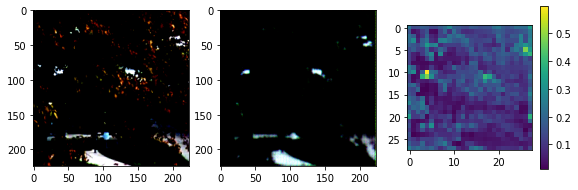

In [53]:
visualize_in_out(1, False)

In [54]:
mse = (imgs_npy - imgs_out_npy)**2
mse.mean(axis=(0, 1, 2))

array([0.12576577, 0.070791  , 0.09574895], dtype=float32)

In [55]:
def dot(a, b):
    return np.einsum('hwc,hwc->hw', a, b)

# Project the vectors in a onto the plane normal to the vector (1, 1, 1)
def project_normal(a):
    # a * (1, 1, 1) = sum(a), ||(1, 1, 1)||^2 = 3
    # All components of the projection onto (1, 1, 1) are equal
    proj = np.sum(a, axis=-1, keepdims=True) / 3
    return a - proj

# Compute pixelwise "cosine similarity" to compare the hues of all pixels in the reconstructed vs. original images.
def similarity(i):
    # Project pixel values onto the plane normal to the vector (1, 1, 1) (gray)
    hue, hue_out = project_normal(imgs_npy[i]), project_normal(imgs_out_npy[i])
    # Dot product of image pixels
    dot_prod = dot(hue, hue_out)
    # Square magnitudes of pixels in each image
    imgs_magsq = dot(hue, hue)
    imgs_out_magsq = dot(hue_out, hue_out)
    return dot_prod / np.sqrt(imgs_magsq * imgs_out_magsq + 1e-6) # to scale by sqrt(imgs_out_magsq)

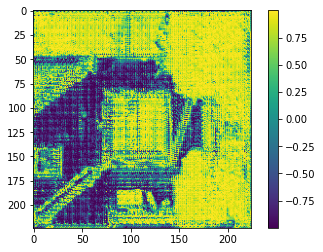

In [56]:
plt.imshow(similarity(0))
plt.colorbar()

## Saving the model

In [ ]:
torch.save(autoencoder.state_dict(), '../autoencoder.pt')